In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import calendar
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances
import warnings
warnings.filterwarnings('ignore')

In [2]:
num_seed_hp = 5
splits_hp = 5
seed_hp = 42
basic_seed = 42
num_trial = 20

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
international_trade_csv = pd.read_csv('data/international_trade.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
train_df = train_df.replace([np.inf, -np.inf, np.nan, -np.nan], 0)
test_df = test_df.replace([np.inf, -np.inf, np.nan, -np.nan], 0)

In [4]:
dic_train = {}
for idx, time in enumerate(train_df['timestamp'].unique()):
    time = time.replace('-', '')
    dic_train[time] = idx+1
    
dic_test = {}
for idx, time in enumerate(test_df['timestamp'].unique()):
    time = time.replace('-', '')
    dic_test[time] = idx+1524

In [5]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))
train_df['weekday'] = train_df['timestamp'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d').weekday())
train_df['prod_ID'] = train_df['ID'].apply(lambda x: x[0:6])
train_df['d'] = train_df['ID'].apply(lambda x: f'd_{dic_train[x[7:]]}')
# train_df.drop(['supply(kg)', 'timestamp'], axis=1, inplace=True)

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))
test_df['weekday'] = test_df['timestamp'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d').weekday())
test_df['prod_ID'] = test_df['ID'].apply(lambda x: x[0:6])
test_df['d'] = test_df['ID'].apply(lambda x: f'd_{dic_test[x[7:]]}')
# test_df.drop(['timestamp'], axis=1, inplace=True)

이동 평균

In [6]:
train_df.rename(columns={'price(원/kg)':'price', 'supply(kg)': 'supply'}, inplace=True)

In [7]:
def get_moving_average(df):
    for win in [1, 2, 4, 8]:
        df['rm_diff_price_{}'.format(win)] = df[['item', 'corporation', 'location', 'price']].groupby(
            ['item', 'corporation', 'location'])['price'].transform(lambda x : x.rolling(win).mean())
        df['rm_diff_price_{}'.format(win)] = ((df['price'] - df['rm_diff_price_{}'.format(win)]
                                                  )/df['price']).round(3)
    return df
train_df = get_moving_average(train_df)

In [8]:
def lags_wins(df):
    lags = [7, 14, 28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["prod_ID","price"]].groupby("prod_ID")["price"].shift(lag)

    wins = [7, 14, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["prod_ID", lag_col]].groupby("prod_ID")[lag_col].transform(lambda x : x.rolling(win).mean())
    return df
train_df = lags_wins(train_df)

In [27]:
valid_df = train_df.copy()
# for day in range(1496, 1524):
#     valid_df.loc[valid_df['d']==f'd_{day}', ['price', 'rm_diff_price_1', 'rm_diff_price_2', 'rm_diff_price_4',
#        'rm_diff_price_8', 'lag_7', 'lag_14', 'lag_28', 'rmean_7_7',
#        'rmean_14_7', 'rmean_28_7', 'rmean_7_14', 'rmean_14_14', 'rmean_28_14',
#        'rmean_7_28', 'rmean_14_28', 'rmean_28_28']] = 0

In [29]:
test_df['price'] = 0
# test_df[['rm_diff_price_1', 'rm_diff_price_2', 'rm_diff_price_4',
#        'rm_diff_price_8', 'lag_7', 'lag_14', 'lag_28', 'rmean_7_7',
#        'rmean_14_7', 'rmean_28_7', 'rmean_7_14', 'rmean_14_14', 'rmean_28_14',
#        'rmean_7_28', 'rmean_14_28', 'rmean_28_28']] = 0.0
test_df = pd.concat([train_df, test_df])

In [30]:
train_lab = train_df.copy()
test_lab = test_df.copy()

for col in train_lab.columns:
    if train_lab[col].dtypes=='object' or train_lab[col].dtypes=='int64':
        train_lab[col] = train_lab[col].astype('category')
        test_lab[col] = test_lab[col].astype('category')

train_df = train_lab.copy()
test_df = test_lab.copy()

print('Category Encoding Completed')

Category Encoding Completed


In [12]:
category_cols = ['item','corporation', 'location', 'year', 'month', 'day', 'weekday']
useless_cols = ['ID', 'prod_ID', 'd', 'supply', 'timestamp', 'price']
train_cols = train_df.columns[~train_df.columns.isin(useless_cols)]
df = train_df.copy()
days_train = ['d_'+str(c) for c in range(1, 1496)]
days_val = ['d_'+str(c) for c in range(1496, 1524)]
df = df.replace([np.inf, -np.inf, np.nan, -np.nan], 0)
#df.iloc[:, -9:] = df.iloc[:, -9:].fillna(0.0)
X_train = df[df['d'].isin(days_train)==True][train_cols]
Y_train = df[df['d'].isin(days_train)==True]["price"]
X_val_df = df[df['d'].isin(days_val)==True]
X_val_df["timestamp"] = pd.to_datetime(X_val_df["timestamp"])
X_val_dff = pd.DataFrame()
for delta in range(0, 28):
    day = datetime(2023, 2, 4) + timedelta(days=delta)
    vl = X_val_df.loc[X_val_df.timestamp == day]
    X_val_dff = pd.concat([X_val_dff, vl])

X_val = X_val_dff[train_cols]
y_val = X_val_dff["price"]

In [13]:
def lgb_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, num_seed_hp):
        params_lgb = {
            "random_state": seed_hp,
            "verbosity": -1,
            "n_estimators": 10000,
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-1), # default=0.1, range=[0,1]
            "max_depth": trial.suggest_int("max_depth", 4, 8), # default=-1
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+2), # default=0
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+2), # default=0
            "num_leaves": trial.suggest_int("num_leaves", 31, 5000), # default=31, range=(1,130172]
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 1.0), # feature_fraction, default=1
            "subsample": trial.suggest_uniform("subsample", 0.3, 1.0), # bagging_fraction, default=1, range=[0,1]
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 20), # bagging_freq, default=0
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 40), # min_data_in_leaf, default=20 
#             "max_bin": trial.suggest_int("max_bin", 100, 500),
        }

        kfold = KFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True)
        cv = np.zeros(X_train.shape[0])

        for n, (train_idx, val_idx) in enumerate(kfold.split(X_train, Y_train)):

            x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train, y_val = Y_train.iloc[train_idx].values, Y_train.iloc[val_idx].values

            lgbmodel = LGBMRegressor(**params_lgb)
                                                                                           
            lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1) 
            cv[val_idx] = lgbmodel.predict(x_val)
            
        cv = np.where(cv<100, 0, cv)
        score_hp.append(mean_squared_error(Y_train, cv))
        print(f'Seed{seed_hp} RMSE: {mean_squared_error(Y_train, cv)}')
    
    np.mean(score_hp)
    return np.mean(score_hp)

In [14]:
sampler = TPESampler(seed=basic_seed)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="minimize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=num_trial)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'n_estimators':10000}
lgb_best_hyperparams.update(lgb_base_hyperparams)

# with open('../pkl/lgb_best_hyperparams.pickle', 'wb') as fw:
#     pickle.dump(lgb_best_hyperparams, fw)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2023-11-10 09:46:30,714] A new study created in memory with name: lgb_parameter_opt


Seed806 RMSE: 135982.1763116117
Seed438 RMSE: 125801.73029701265
Seed70 RMSE: 132923.06083913855
Seed896 RMSE: 129683.45245585669


[I 2023-11-10 09:47:35,553] Trial 0 finished with value: 130948.94555084566 and parameters: {'learning_rate': 0.023688639503640783, 'max_depth': 8, 'reg_alpha': 8.471801418819979, 'reg_lambda': 2.481040974867813, 'num_leaves': 806, 'colsample_bytree': 0.40919616423534183, 'subsample': 0.3406585285177396, 'subsample_freq': 18, 'min_child_samples': 25}. Best is trial 0 with value: 130948.94555084566.


Seed545 RMSE: 130354.30785060872
Seed362 RMSE: 139367.62931725857
Seed869 RMSE: 138292.30949991077
Seed694 RMSE: 141738.9808950887
Seed339 RMSE: 138185.31570194027


[I 2023-11-10 09:48:11,565] Trial 1 finished with value: 139719.3986815922 and parameters: {'learning_rate': 0.051059032093947576, 'max_depth': 4, 'reg_alpha': 75.7947995334801, 'reg_lambda': 21.368329072358772, 'num_leaves': 1086, 'colsample_bytree': 0.42727747704497043, 'subsample': 0.4283831568974037, 'subsample_freq': 7, 'min_child_samples': 21}. Best is trial 0 with value: 130948.94555084566.


Seed795 RMSE: 141012.75799376259
Seed896 RMSE: 129892.56592327917
Seed15 RMSE: 120881.17092437518
Seed894 RMSE: 126953.24968914698
Seed282 RMSE: 128552.61174171421


[I 2023-11-10 09:49:11,505] Trial 2 finished with value: 126191.43839204847 and parameters: {'learning_rate': 0.027036160666620016, 'max_depth': 5, 'reg_alpha': 2.801635158716261, 'reg_lambda': 0.03613894271216528, 'num_leaves': 1482, 'colsample_bytree': 0.5564532903055841, 'subsample': 0.619248988951925, 'subsample_freq': 16, 'min_child_samples': 8}. Best is trial 2 with value: 126191.43839204847.


Seed920 RMSE: 124677.5936817268
Seed701 RMSE: 110989.51435842902
Seed328 RMSE: 108436.49066369762
Seed715 RMSE: 112815.78994248649
Seed315 RMSE: 110291.09696902345


[I 2023-11-10 09:51:30,407] Trial 3 finished with value: 110467.49894121273 and parameters: {'learning_rate': 0.032676417657817626, 'max_depth': 6, 'reg_alpha': 0.015339162591163621, 'reg_lambda': 2.69264691008618, 'num_leaves': 878, 'colsample_bytree': 0.3455361150896956, 'subsample': 0.9642198760773333, 'subsample_freq': 20, 'min_child_samples': 33}. Best is trial 3 with value: 110467.49894121273.


Seed277 RMSE: 109804.60277242702
Seed933 RMSE: 156871.1476520683
Seed134 RMSE: 156553.56996760616
Seed172 RMSE: 158611.58532658144
Seed501 RMSE: 159071.46402030214


[I 2023-11-10 09:51:55,136] Trial 4 finished with value: 157882.49093827378 and parameters: {'learning_rate': 0.020165721691808594, 'max_depth': 4, 'reg_alpha': 5.456725485601478, 'reg_lambda': 0.5762487216478605, 'num_leaves': 637, 'colsample_bytree': 0.6466238370778892, 'subsample': 0.32407196478065287, 'subsample_freq': 19, 'min_child_samples': 11}. Best is trial 3 with value: 110467.49894121273.


Seed7 RMSE: 158304.68772481085
Seed956 RMSE: 122330.64887112915
Seed644 RMSE: 122291.74060155211
Seed413 RMSE: 123199.65640309516
Seed520 RMSE: 123140.69124446441


[I 2023-11-10 09:52:42,387] Trial 5 finished with value: 123024.21238082596 and parameters: {'learning_rate': 0.04597505784732168, 'max_depth': 5, 'reg_alpha': 1.2030178871154673, 'reg_lambda': 1.5375920235481764, 'num_leaves': 949, 'colsample_bytree': 0.9787092394351908, 'subsample': 0.8425929763527802, 'subsample_freq': 19, 'min_child_samples': 36}. Best is trial 3 with value: 110467.49894121273.


Seed77 RMSE: 124158.32478388898
Seed214 RMSE: 116674.01998997648
Seed536 RMSE: 115659.98604971694
Seed233 RMSE: 116792.87332718958
Seed838 RMSE: 113784.98319779673


[I 2023-11-10 09:53:57,204] Trial 6 finished with value: 115505.23861074793 and parameters: {'learning_rate': 0.03961867790406585, 'max_depth': 8, 'reg_alpha': 0.022592797420156956, 'reg_lambda': 0.06080390190296603, 'num_leaves': 255, 'colsample_bytree': 0.527731231534285, 'subsample': 0.5720741027826374, 'subsample_freq': 6, 'min_child_samples': 34}. Best is trial 3 with value: 110467.49894121273.


Seed297 RMSE: 114614.33048905987
Seed57 RMSE: 112167.33426634457
Seed12 RMSE: 110217.2400042739
Seed324 RMSE: 113368.04686288367
Seed25 RMSE: 112670.5213561531


[I 2023-11-10 09:57:29,117] Trial 7 finished with value: 112184.33239807215 and parameters: {'learning_rate': 0.02273805573563183, 'max_depth': 5, 'reg_alpha': 1.4817820606039094, 'reg_lambda': 0.0366181922039243, 'num_leaves': 4017, 'colsample_bytree': 0.35218545057583955, 'subsample': 0.9908208556203622, 'subsample_freq': 16, 'min_child_samples': 8}. Best is trial 3 with value: 110467.49894121273.


Seed512 RMSE: 112498.51950070553
Seed303 RMSE: 111130.49220167051
Seed363 RMSE: 116012.680590851
Seed52 RMSE: 115010.38669161081
Seed105 RMSE: 117519.00098038588


[I 2023-11-10 10:03:27,209] Trial 8 finished with value: 115159.12150226001 and parameters: {'learning_rate': 0.010127963257331486, 'max_depth': 8, 'reg_alpha': 6.720930050156114, 'reg_lambda': 8.241925264876453, 'num_leaves': 3864, 'colsample_bytree': 0.35183125621386324, 'subsample': 0.5509260099809907, 'subsample_freq': 3, 'min_child_samples': 35}. Best is trial 3 with value: 110467.49894121273.


Seed428 RMSE: 116123.04704678184
Seed684 RMSE: 123710.6097047067
Seed414 RMSE: 125743.19948482553
Seed953 RMSE: 121177.56573285398
Seed293 RMSE: 127625.03849600468


[I 2023-11-10 10:04:10,084] Trial 9 finished with value: 124350.63968645032 and parameters: {'learning_rate': 0.042004723167022, 'max_depth': 5, 'reg_alpha': 0.01795698422567764, 'reg_lambda': 0.17535949529764422, 'num_leaves': 1647, 'colsample_bytree': 0.8107243248366449, 'subsample': 0.7462902299486491, 'subsample_freq': 18, 'min_child_samples': 19}. Best is trial 3 with value: 110467.49894121273.


Seed614 RMSE: 123496.78501386064
Seed810 RMSE: 104446.68506126563
Seed466 RMSE: 102311.81061499876
Seed870 RMSE: 103218.15382911504
Seed976 RMSE: 106559.41816690224


[I 2023-11-10 10:05:59,981] Trial 10 finished with value: 105083.55132384722 and parameters: {'learning_rate': 0.08813259224734654, 'max_depth': 7, 'reg_alpha': 0.1051466648506654, 'reg_lambda': 53.59957765771799, 'num_leaves': 2611, 'colsample_bytree': 0.7831729514984018, 'subsample': 0.9811585000411431, 'subsample_freq': 12, 'min_child_samples': 27}. Best is trial 10 with value: 105083.55132384722.


Seed342 RMSE: 108881.68894695445
Seed261 RMSE: 105822.39834648608
Seed677 RMSE: 107543.09544990119
Seed419 RMSE: 108764.54634023718
Seed665 RMSE: 105645.50007895901


[I 2023-11-10 10:07:42,798] Trial 11 finished with value: 106094.45312517013 and parameters: {'learning_rate': 0.09905863952084676, 'max_depth': 7, 'reg_alpha': 0.0984282995794434, 'reg_lambda': 70.5744035944207, 'num_leaves': 2693, 'colsample_bytree': 0.7918894629305991, 'subsample': 0.9776931953922378, 'subsample_freq': 12, 'min_child_samples': 28}. Best is trial 10 with value: 105083.55132384722.


Seed667 RMSE: 102696.72541026714
Seed708 RMSE: 109118.56530803026
Seed541 RMSE: 113230.34566555319
Seed63 RMSE: 113325.45201009563
Seed874 RMSE: 109831.68786866908


[I 2023-11-10 10:09:08,317] Trial 12 finished with value: 111613.28591919616 and parameters: {'learning_rate': 0.09268966212590594, 'max_depth': 7, 'reg_alpha': 0.15278618004189032, 'reg_lambda': 98.86560521091086, 'num_leaves': 2991, 'colsample_bytree': 0.802422187238993, 'subsample': 0.8677645534248755, 'subsample_freq': 11, 'min_child_samples': 27}. Best is trial 10 with value: 105083.55132384722.


Seed929 RMSE: 112560.37874363262
Seed997 RMSE: 110330.64309800704
Seed690 RMSE: 112020.69313527674
Seed150 RMSE: 112638.06243383439
Seed973 RMSE: 113341.52352059446


[I 2023-11-10 10:10:41,103] Trial 13 finished with value: 111576.99893042231 and parameters: {'learning_rate': 0.09908696623768996, 'max_depth': 7, 'reg_alpha': 0.1694676201522362, 'reg_lambda': 99.41450502972614, 'num_leaves': 2627, 'colsample_bytree': 0.8020102143044041, 'subsample': 0.8512889080148068, 'subsample_freq': 12, 'min_child_samples': 28}. Best is trial 10 with value: 105083.55132384722.


Seed773 RMSE: 109554.07246439895
Seed197 RMSE: 113368.01934737012
Seed740 RMSE: 119571.48601477964
Seed17 RMSE: 117717.55883662277
Seed28 RMSE: 115562.72172221064


[I 2023-11-10 10:11:46,614] Trial 14 finished with value: 116843.82628341073 and parameters: {'learning_rate': 0.06686053249773777, 'max_depth': 7, 'reg_alpha': 0.2049646860453726, 'reg_lambda': 22.60210831274048, 'num_leaves': 4974, 'colsample_bytree': 0.9302723308626759, 'subsample': 0.7465644751106153, 'subsample_freq': 13, 'min_child_samples': 17}. Best is trial 10 with value: 105083.55132384722.


Seed243 RMSE: 117999.34549607044
Seed213 RMSE: 109796.59870995788
Seed759 RMSE: 110292.73950372983
Seed964 RMSE: 107446.81463417313
Seed195 RMSE: 110443.01087214045


[I 2023-11-10 10:13:12,680] Trial 15 finished with value: 108644.22309646262 and parameters: {'learning_rate': 0.06991446702656358, 'max_depth': 6, 'reg_alpha': 0.06876418347696565, 'reg_lambda': 25.552085852158772, 'num_leaves': 2069, 'colsample_bytree': 0.7154135123264462, 'subsample': 0.9121650031612786, 'subsample_freq': 8, 'min_child_samples': 40}. Best is trial 10 with value: 105083.55132384722.


Seed102 RMSE: 105241.95176231182
Seed405 RMSE: 112055.2264068679
Seed352 RMSE: 115611.33487426286
Seed80 RMSE: 115348.63662554731
Seed202 RMSE: 111914.75139682797


[I 2023-11-10 10:15:04,157] Trial 16 finished with value: 114052.89602284021 and parameters: {'learning_rate': 0.06644718456775066, 'max_depth': 7, 'reg_alpha': 0.35118049643870236, 'reg_lambda': 7.040539354233142, 'num_leaves': 3277, 'colsample_bytree': 0.8783980260314873, 'subsample': 0.7555173191865091, 'subsample_freq': 14, 'min_child_samples': 1}. Best is trial 10 with value: 105083.55132384722.


Seed165 RMSE: 115334.53081069497
Seed706 RMSE: 106091.54076871034
Seed876 RMSE: 108680.25958054821
Seed136 RMSE: 111392.94054526491
Seed331 RMSE: 111941.85572775829


[I 2023-11-10 10:16:31,389] Trial 17 finished with value: 109379.15461343716 and parameters: {'learning_rate': 0.08033610886163586, 'max_depth': 6, 'reg_alpha': 0.0522422026531857, 'reg_lambda': 46.15308130327799, 'num_leaves': 2171, 'colsample_bytree': 0.6986988606265796, 'subsample': 0.9317868240189493, 'subsample_freq': 10, 'min_child_samples': 30}. Best is trial 10 with value: 105083.55132384722.


Seed295 RMSE: 108789.17644490408
Seed57 RMSE: 100778.19821735573
Seed259 RMSE: 102957.85829464022
Seed730 RMSE: 99078.95337966806
Seed657 RMSE: 102435.02449390072


[I 2023-11-10 10:21:54,839] Trial 18 finished with value: 101593.85596497006 and parameters: {'learning_rate': 0.016017397876891614, 'max_depth': 7, 'reg_alpha': 0.6232943011592377, 'reg_lambda': 0.010367837567056771, 'num_leaves': 3539, 'colsample_bytree': 0.6148622862977107, 'subsample': 0.9953522435734125, 'subsample_freq': 9, 'min_child_samples': 24}. Best is trial 18 with value: 101593.85596497006.


Seed427 RMSE: 102719.24543928557
Seed843 RMSE: 105421.28499662945
Seed717 RMSE: 104309.42170819288
Seed535 RMSE: 102526.06333845215
Seed962 RMSE: 103557.67045506489


[I 2023-11-10 10:28:25,032] Trial 19 finished with value: 104237.34770021385 and parameters: {'learning_rate': 0.016137800121662917, 'max_depth': 8, 'reg_alpha': 0.6084101781450121, 'reg_lambda': 0.014886870077699794, 'num_leaves': 3841, 'colsample_bytree': 0.5691766216673199, 'subsample': 0.7999012751980358, 'subsample_freq': 4, 'min_child_samples': 22}. Best is trial 18 with value: 101593.85596497006.


Seed344 RMSE: 105372.29800272989
The best hyperparameters are:
 {'learning_rate': 0.016017397876891614, 'max_depth': 7, 'reg_alpha': 0.6232943011592377, 'reg_lambda': 0.010367837567056771, 'num_leaves': 3539, 'colsample_bytree': 0.6148622862977107, 'subsample': 0.9953522435734125, 'subsample_freq': 9, 'min_child_samples': 24, 'n_estimators': 10000}


In [ ]:
The best hyperparameters are:
 {'learning_rate': 0.016017397876891614, 'max_depth': 7, 'reg_alpha': 0.6232943011592377, 'reg_lambda': 0.010367837567056771, 'num_leaves': 3539, 'colsample_bytree': 0.6148622862977107, 'subsample': 0.9953522435734125, 'subsample_freq': 9, 'min_child_samples': 24, 'n_estimators': 10000}

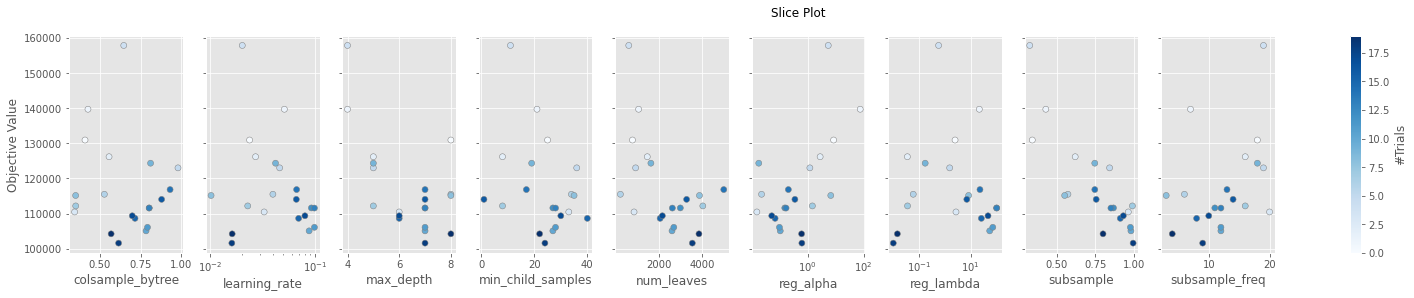

In [69]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

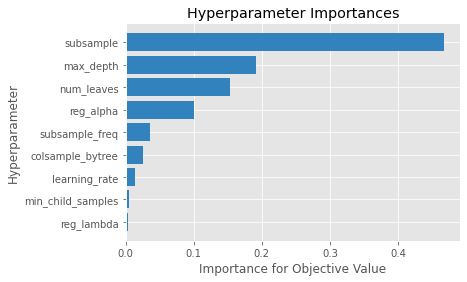

In [70]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

In [52]:
len(val_dataset)

28

In [44]:
valid_df = valid_df.replace([np.inf, -np.inf, np.nan, -np.nan], 0)
test_df = test_df.replace([np.inf, -np.inf, np.nan, -np.nan], 0)

In [66]:
valid_df

,ID,timestamp,item,corporation,location,supply,price,year,month,day,...,lag_28,rmean_7_7,rmean_14_7,rmean_28_7,rmean_7_14,rmean_14_14,rmean_28_14,rmean_7_28,rmean_14_28,rmean_28_28
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27,...,604.0,528.142857,372.428571,402.000000,450.285714,433.642857,355.142857,449.357143,394.392857,377.642857
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28,...,719.0,519.285714,390.428571,504.714286,454.857143,420.642857,377.285714,466.321429,398.964286,383.214286
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1,...,646.0,497.857143,416.714286,507.428571,457.285714,416.642857,393.571429,459.642857,405.107143,386.607143
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2,...,620.0,456.142857,464.714286,500.714286,460.428571,421.500000,406.785714,449.964286,414.142857,391.642857


In [61]:
valid_df_pivot = valid_df.pivot(index=None, columns='d', values='price')

In [74]:
len(valid_df_pivot.d_30.unique())

36

In [45]:
train_dataset = valid_df.iloc[:, -112:-28]
val_dataset = valid_df.iloc[:, -28:]
train_data = test_df.iloc[:, -28-365:-28]
val_data = test_df.iloc[:, -28:]

In [48]:
period = 30
prediction_sma = train_dataset.iloc[:, -period:].copy() 
for i in range(len(val_dataset.loc[0])): 
    prediction_sma['F'+str(i+1)] = prediction_sma.iloc[:, -period:].mean(axis=1) 
prediction_sma = prediction_sma[['F'+str(i+1) for i in range(len(val_dataset.loc[0]))]] 
r = evaluator.score(prediction_sma.values)
print('wrmsse:', wrmsse_sma)

In [ ]:
period = 30
test_pred_y_sma = train_data.iloc[:, -period:].copy() 
for i in range(len(val_data.loc[0])): 
    test_pred_y_sma['F'+str(i+1)] = test_pred_y_sma.iloc[:, -period:].mean(axis=1) 
test_pred_y_sma = test_pred_y_sma[['F'+str(i+1) for i in range(len(val_data.loc[0]))]].values